# Comparison of Cloud Top SLF values from NorESM2 and CALIOP
Just like parameterspace.ipynb

In [1]:
import sys

# Add last directory to path
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis")
# Add common resources
sys.path.append("/mnt/mcc-ns9600k/jonahks/git_repos/netcdf_analysis/Common/")

from imports import (
    pd, np, xr, mpl, plt, sns, os, 
    datetime, crt, gridspec,
    polyfit, ccrs, LinearRegression, metrics
    )

from functions import (
    masked_average, interpretNS, plot_slf_isotherms, 
    add_weights, process_caliop, process_for_slf,
    noresm_slf_to_df, regress_1d
    )

from classes import CT_SLF_Metric

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
host = os.uname()[1]
if 'jupyter' in host.split('-'): # Check if running on NIRD through the Jupyter Hub
    print('Running through MC2 Jupyter Hub')
    op_dir = '/mnt/mcc-ns9600k/jonahks/'
    os.chdir(op_dir)

else:  # Assume that we're running on a local machine and mounting NIRD
    print('Running on %s, attempting to mount ns9600k/jonahks/ from NIRD' % str(host))
    os.system('fusermount -zu ~/drivemount/')  # unmount first
    os.system('sshfs jonahks@login.nird.sigma2.no:"p/jonahks/" ~/drivemount/')    # Calling mountnird from .bashrc doesn't work
    os.chdir('/home/jonahks/drivemount/')
    save_dir = '~/DATAOUT/'
    save_to = os.path.expanduser(save_dir)

obs_dir = 'caliop_slfs/'
output_dir = 'figures/'
case_dir = 'mnth15runs/' # inconsistent label compared to jupy_test
    
# Check that each important directory can be accessed:    
access_paths = os.path.exists(obs_dir) and os.path.exists(output_dir) and os.path.exists(case_dir)
print('Can access all directory paths:', access_paths)

Running through MC2 Jupyter Hub
Can access all directory paths: True


In [3]:
#all_cases = os.listdir('/home/jonahks/drivemount/mnth15runs/')
all_cases = os.listdir(case_dir)

all_cases

['20200112_002538_singleparam_nudge_wbf_1_inp_0',
 '20200116_130416_nudged_wbfmods_wbf_10_inp_1',
 '20191230_130025_singleparam_cttest15_wbf_1_inp_1',
 '20191217_145440_singleparam_jolt_wbf_1_inp_1000',
 '20200110_142006_singleparam_nudge_wbf_1_inp_1000',
 '20191128_171713_sampleparamset_wbf_10_inp_1',
 '20191209_180424_sampleparamset_wbf_1_inp_0.1',
 'error_vs_iso.png',
 '.ipynb_checkpoints',
 'unused',
 '20191127_162007_sampleparamset_wbf_0.01_inp_1',
 'runs_as_vectors.png',
 '20191210_152149_sampleparamset_wbf_1_inp_0.1',
 '20200109_1541_wbf_1.0_inp_1.0',
 '20200128_142303_singleparam_frzrtvarsm15_wbf_1_inp_100',
 '20191128_171713_sampleparamset_wbf_1_inp_10',
 '20200204_120214_singleparam_wbfcheck_wbf_0.1_inp_1',
 '20191219_151155_singleparam_cttest_wbf_1_inp_1.cam.h0.0001-01',
 '20200204_113441_singleparam_inpcheck_wbf_1_inp_10',
 '20191210_152149_sampleparamset_wbf_1_inp_10',
 '20191217_134307_singleparam_jolt_wbf_1_inp_0',
 '20200116_130416_nudged_wbfmods_wbf_0.01_inp_1',
 'para

In [4]:
base_case = '20200109_1541_wbf_1.0_inp_1.0'
cases = ['20200109_1541_wbf_1.0_inp_1.0', 
         '20200110_142006_singleparam_nudge_wbf_1_inp_1000',
         '20200112_002538_singleparam_nudge_wbf_1_inp_0',
         '20200116_130416_nudged_wbfmods_wbf_0.01_inp_1',
         '20200204_113441_singleparam_inpcheck_wbf_1_inp_10',
         '20200204_120214_singleparam_wbfcheck_wbf_0.1_inp_1',
         '20200116_130416_nudged_wbfmods_wbf_10_inp_1']

inp_mods_only = ['20200109_1541_wbf_1.0_inp_1.0', 
                 '20200112_002538_singleparam_nudge_wbf_1_inp_0',
                 '20200204_113441_singleparam_inpcheck_wbf_1_inp_10',
                 '20200128_142303_singleparam_frzrtvarsm15_wbf_1_inp_100',
                 '20200110_142006_singleparam_nudge_wbf_1_inp_1000']

wbf_mods_only = ['20200109_1541_wbf_1.0_inp_1.0',
                 '20200116_130416_nudged_wbfmods_wbf_0.01_inp_1',
                 '20200204_120214_singleparam_wbfcheck_wbf_0.1_inp_1',
                 '20200116_130416_nudged_wbfmods_wbf_10_inp_1']

In [19]:
wbf_only_metric = CT_SLF_Metric(case_dir)

for i in wbf_mods_only:
    wbf_only_metric.add_case(i)
wbf_only_metric.set_origin(base_case)

mnth15runs/20200109_1541_wbf_1.0_inp_1.0/20200109_1541_wbf_1.0_inp_1.0_slfvars.nc
mnth15runs/20200116_130416_nudged_wbfmods_wbf_0.01_inp_1/20200116_130416_nudged_wbfmods_wbf_0.01_inp_1_slfvars.nc


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


mnth15runs/20200204_120214_singleparam_wbfcheck_wbf_0.1_inp_1/20200204_120214_singleparam_wbfcheck_wbf_0.1_inp_1_slfvars.nc
mnth15runs/20200116_130416_nudged_wbfmods_wbf_10_inp_1/20200116_130416_nudged_wbfmods_wbf_10_inp_1_slfvars.nc


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [20]:
inp_only_metric = CT_SLF_Metric(case_dir)

for i in inp_mods_only:
    inp_only_metric.add_case(i)
inp_only_metric.set_origin(base_case)

mnth15runs/20200109_1541_wbf_1.0_inp_1.0/20200109_1541_wbf_1.0_inp_1.0_slfvars.nc
mnth15runs/20200112_002538_singleparam_nudge_wbf_1_inp_0/20200112_002538_singleparam_nudge_wbf_1_inp_0_slfvars.nc


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


mnth15runs/20200204_113441_singleparam_inpcheck_wbf_1_inp_10/20200204_113441_singleparam_inpcheck_wbf_1_inp_10_slfvars.nc
mnth15runs/20200128_142303_singleparam_frzrtvarsm15_wbf_1_inp_100/20200128_142303_singleparam_frzrtvarsm15_wbf_1_inp_100_slfvars.nc


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


mnth15runs/20200110_142006_singleparam_nudge_wbf_1_inp_1000/20200110_142006_singleparam_nudge_wbf_1_inp_1000_slfvars.nc


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


In [21]:
test = CT_SLF_Metric(case_dir)

for i in cases:
    test.add_case(i)
test.set_origin(base_case)

mnth15runs/20200109_1541_wbf_1.0_inp_1.0/20200109_1541_wbf_1.0_inp_1.0_slfvars.nc
mnth15runs/20200110_142006_singleparam_nudge_wbf_1_inp_1000/20200110_142006_singleparam_nudge_wbf_1_inp_1000_slfvars.nc
mnth15runs/20200112_002538_singleparam_nudge_wbf_1_inp_0/20200112_002538_singleparam_nudge_wbf_1_inp_0_slfvars.nc
mnth15runs/20200116_130416_nudged_wbfmods_wbf_0.01_inp_1/20200116_130416_nudged_wbfmods_wbf_0.01_inp_1_slfvars.nc
mnth15runs/20200204_113441_singleparam_inpcheck_wbf_1_inp_10/20200204_113441_singleparam_inpcheck_wbf_1_inp_10_slfvars.nc


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


mnth15runs/20200204_120214_singleparam_wbfcheck_wbf_0.1_inp_1/20200204_120214_singleparam_wbfcheck_wbf_0.1_inp_1_slfvars.nc
mnth15runs/20200116_130416_nudged_wbfmods_wbf_10_inp_1/20200116_130416_nudged_wbfmods_wbf_10_inp_1_slfvars.nc


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


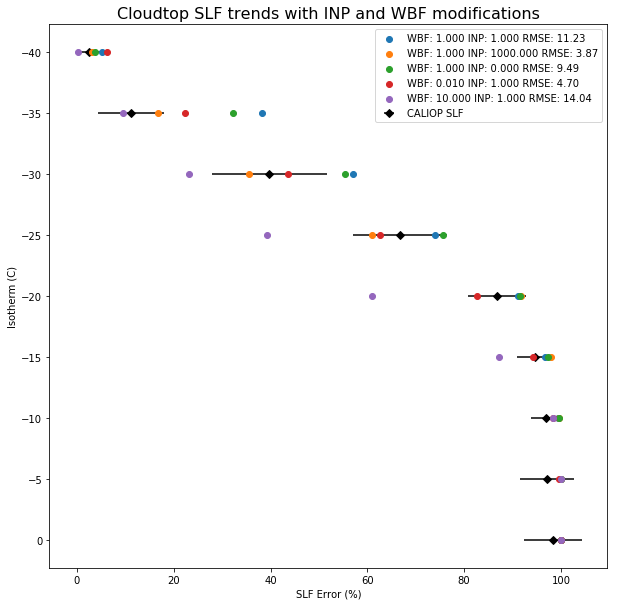

In [6]:
_temp = test.plot_isos_ct()

In [23]:
filename = '%s/inpmods_cloudtops_nudgedruns.png' % (output_dir)

_temp.savefig(filename,format = 'png', dpi = 200)
_temp.clf()

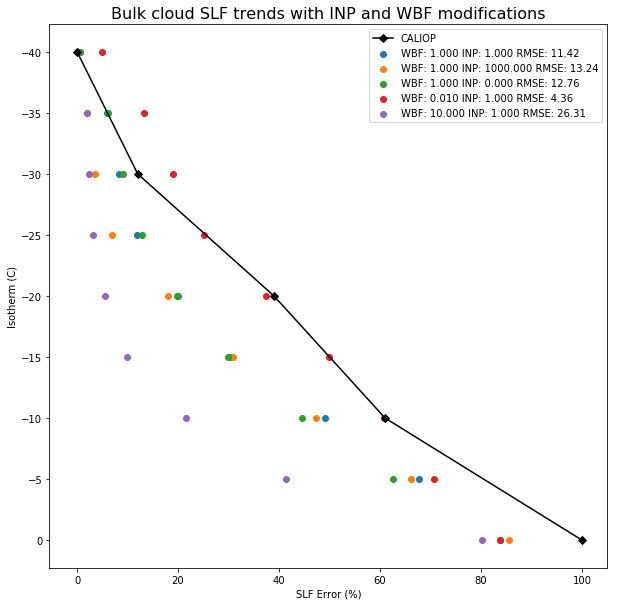

In [7]:
bulkcloud_inp = test.plot_isos_bulk()

In [24]:
filename = '%s/inpmods_bulkclouds_nudgedruns.png' % (output_dir)

bulkcloud_inp.savefig(filename,format = 'png', dpi = 200)
bulkcloud_inp.clf()

/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


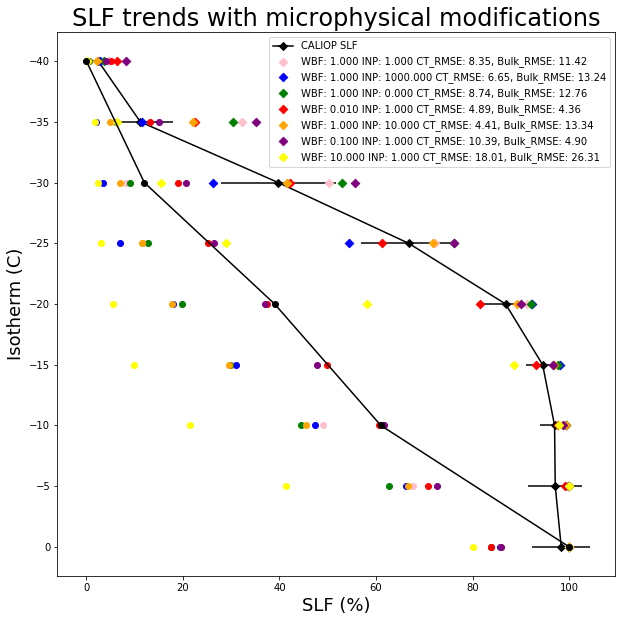

In [22]:
for_battisti = test.plot_isos_all()

In [66]:
filename = '%s/SLFcomparison_nudgedruns.png' % (output_dir)

for_battisti.savefig(filename,format = 'png', dpi = 200)
for_battisti.clf()

/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


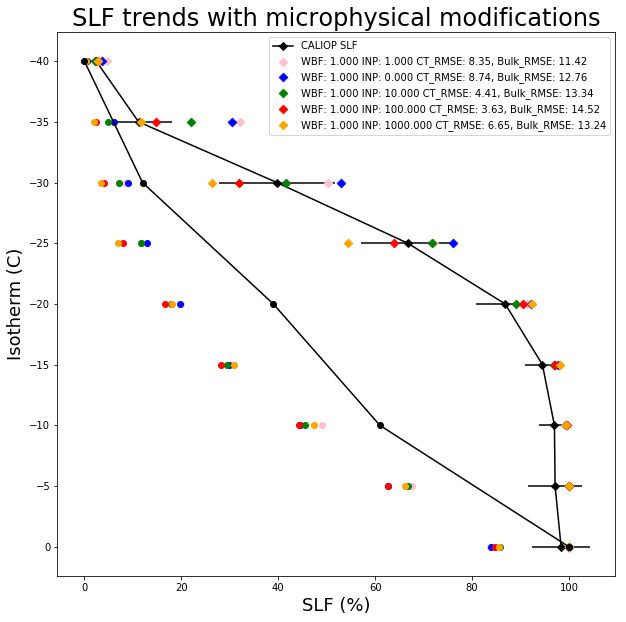

In [23]:
np.seterr(divide='ignore', invalid='ignore')
inp_only = inp_only_metric.plot_isos_all()

In [25]:
filename = '%s/SLFcomparison_INPonly.png' % (output_dir)

inp_only.savefig(filename,format = 'png', dpi = 200)
inp_only.clf()

/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


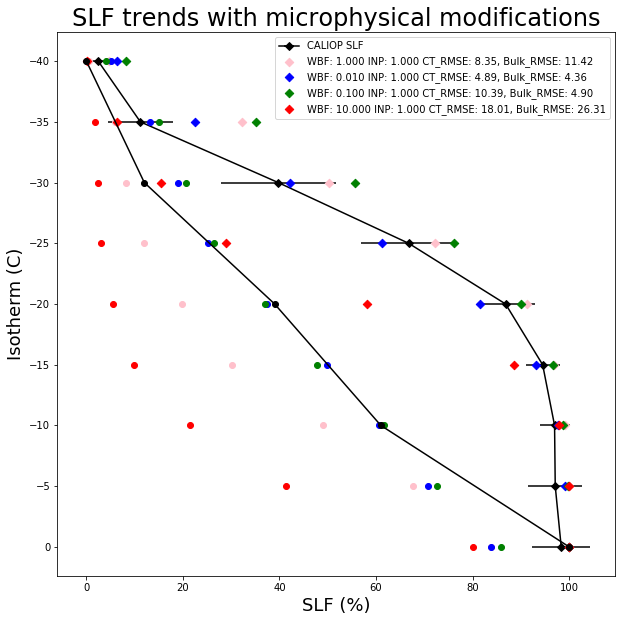

In [25]:
wbf_only = wbf_only_metric.plot_isos_all()

In [70]:
filename = '%s/SLFcomparison_WBFonly.png' % (output_dir)

wbf_only.savefig(filename,format = 'png', dpi = 200)
wbf_only.clf()

In [6]:
control_metric = CT_SLF_Metric(case_dir)
control_metric.add_case(base_case)
control_metric.set_origin(base_case)

mnth15runs/20200109_1541_wbf_1.0_inp_1.0/20200109_1541_wbf_1.0_inp_1.0_slfvars.nc


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


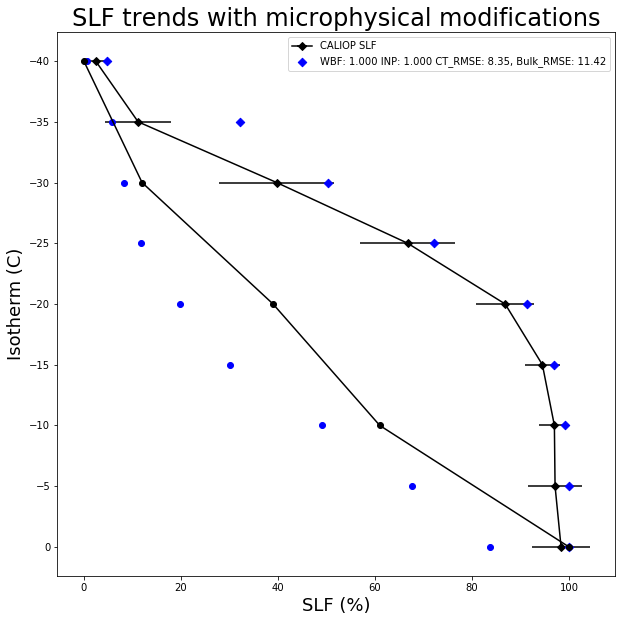

In [8]:
forfulb = control_metric.plot_isos_all()

In [10]:
filename = '%s/SLFcomparison_control_only.png' % (output_dir)

forfulb.savefig(filename,format = 'png', dpi = 200)
forfulb.clf()

In [11]:
best_cases = ['20200109_1541_wbf_1.0_inp_1.0', 
         '20200116_130416_nudged_wbfmods_wbf_0.01_inp_1',
         '20200204_113441_singleparam_inpcheck_wbf_1_inp_10']

In [12]:
best_metric = CT_SLF_Metric(case_dir)
for i in best_cases:
    best_metric.add_case(i)
best_metric.set_origin(base_case)

mnth15runs/20200109_1541_wbf_1.0_inp_1.0/20200109_1541_wbf_1.0_inp_1.0_slfvars.nc
mnth15runs/20200116_130416_nudged_wbfmods_wbf_0.01_inp_1/20200116_130416_nudged_wbfmods_wbf_0.01_inp_1_slfvars.nc


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


mnth15runs/20200204_113441_singleparam_inpcheck_wbf_1_inp_10/20200204_113441_singleparam_inpcheck_wbf_1_inp_10_slfvars.nc


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


/opt/conda/lib/python3.7/site-packages/xarray/core/nanops.py:140: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


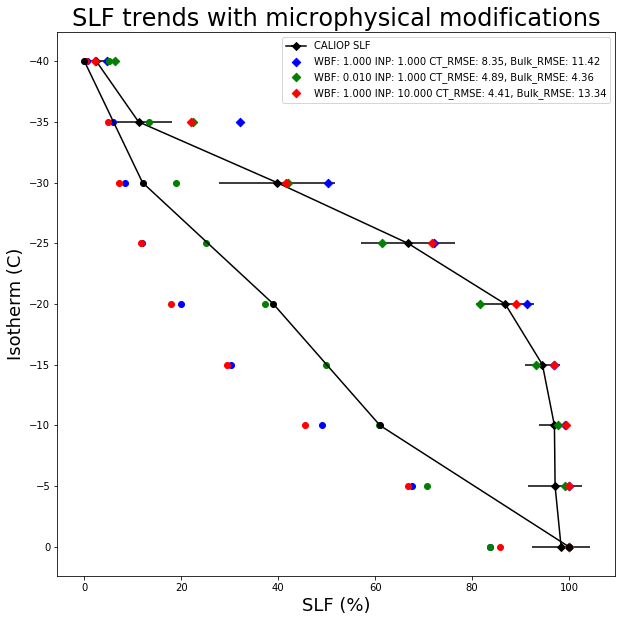

In [13]:
bestall = best_metric.plot_isos_all()

In [14]:
filename = '%s/SLFcomparison_best_only.png' % (output_dir)

bestall.savefig(filename,format = 'png', dpi = 200)
bestall.clf()

In [36]:
test.ct_caliop_slf

<xarray.Dataset>
Dimensions:      (isotherm: 9, lat: 180, lon: 360)
Coordinates:
  * lat          (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon          (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 356.0 357.0 358.0 359.0
  * isotherm     (isotherm) float64 -40.0 -35.0 -30.0 -25.0 ... -10.0 -5.0 0.0
Data variables:
    SLF          (lat, lon, isotherm) float64 ...
    cell_weight  (lat, lon) float64 ...

In [50]:
ds = test_df
# Select dates after a 3 month wind-up and average slf, unless it is a monthlong test run
if (len(ds['time']) > 1):
    try:
        ds['SLF_ISOTM'] = (ds['SLFXCLD_ISOTM'] / ds['CLD_ISOTM']).sel(time=slice('0001-04-01',
                            '0002-03-01'))
    except:
        ds['SLF_ISOTM'] = (ds['SLFXCLD_ISOTM'] / ds['CLD_ISOTM']).sel(time=slice('2000-04-01',
                            '2001-03-01'))
    ds['SLF_ISOTM_TAVG'] = ds['SLF_ISOTM']

In [19]:
filename

'figures//inpmods_nudgedruns.png'

Determining whether to use a linear or logarithmic fit.

In [16]:
def log10effect(INP):
    INPlog10 = np.log10(INP)
    WBF = np.exp(2/3*np.log(INP)-2*np.log(10))
    
    return WBF

def lineareffect(INP):
    WBF = INP*1e-3 + 0.01
    
    return WBF

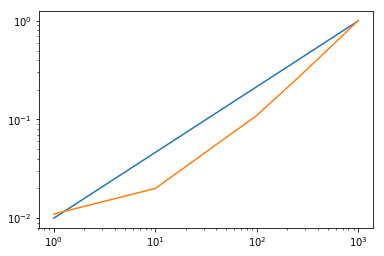

In [90]:
paramplt = plt.loglog(figsize=[10,10])

INPs = np.array([1,10,100,250,500,750,1000])
plt.plot(INPs, log10effect(INPs))
plt.plot(INPs, lineareffect(INPs))

In [91]:
log10effect(INPs)

array([0.01      , 0.04641589, 0.21544347, 0.39685026, 0.62996052,
       0.82548181, 1.        ])

In [92]:
lineareffect(INPs)

array([0.011, 0.02 , 0.11 , 0.26 , 0.51 , 0.76 , 1.01 ])

It doesn't seem to make that big of a difference based on how we fit. At most a factor of two between the suggested WBFs at low INP concentrations.

| INP  | WBF Linear | WBF Log10 |
|------|------------|-----------|
| 1    | 0.011      | 0.01      |
| 10   | 0.02       | 0.046     |
| 100  | 0.11       | 0.215     |
| 250  | 0.26       | 0.397     |
| 500  | 0.51       | 0.630     |
| 750  | 0.76       | 0.825     |
| 1000 | 1.01       | 1         |